# Detecção de Intrusões em Redes Usando Random Forest

Aluno: João Lucas Oliveira Mota - 509597


## 1. Introdução

A segurança em redes de computadores é essencial para proteger sistemas contra ameaças como DoS, DDoS e varreduras de portas, que podem comprometer a integridade e disponibilidade dos serviços. Técnicas de aprendizado de máquina, como Random Forest, são eficazes na detecção automática de intrusões por meio da análise de padrões em dados de tráfego de rede. Este trabalho aplica o Random Forest para classificar eventos de rede, visando melhorar a identificação rápida e precisa de ataques cibernéticos.    


## 2. Fundamentação Teórica

Neste estudo, será utilizada a técnica de **Random Forest**, uma abordagem supervisionada que constrói um conjunto de árvores de decisão para realizar classificações com alta precisão. Essa técnica é conhecida por lidar bem com dados tabulares e problemas de classificação multiclasses.
    


## 3. Metodologia

O dataset escolhido foi retirado da plataforma Kaggle:  
> [Network Intrusion Detection Dataset](https://www.kaggle.com/datasets/sampadab17/network-intrusion-detection)

O conjunto contém registros de tráfego de rede rotulados como normal ou pertencentes a diferentes tipos de ataques.

As etapas metodológicas incluem:

- Carregamento e visualização dos dados
- Limpeza e pré-processamento
- Treinamento do modelo
- Avaliação usando métricas padrão
    

### Pré-Processamento

In [1]:

# 4.1 Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
    

In [2]:

# 4.2 Carregamento do dataset
df = pd.read_csv("Train_data.csv")

# Visualização inicial
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [3]:
print(df.columns)

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class'],
      dtype='object')


In [4]:
# Colunas categóricas nominais
colunas_categoricas = ['protocol_type', 'flag', 'service']

# Dicionário para armazenar os encoders caso precise inverter depois
encoders = {}

for coluna in colunas_categoricas:
    le = LabelEncoder()
    df[coluna] = le.fit_transform(df[coluna])
    encoders[coluna] = le  # Guarda o encoder para possível inversão futura

# # Prints para análise (comente/descomente conforme desejar)
#print(df[colunas_categoricas].head())
# print(df['protocol_type'].unique())
# print(df['flag'].unique())
# print(df['service'].unique())

# Contar valores únicos por coluna
# print(df.nunique().sort_values())

# Verificar colunas com valores nulos
# print(df.isnull().sum())

# Verifica se cada valor é string (ou seja, não numérico)
nao_numericos_por_coluna = df.applymap(lambda x: isinstance(x, str)).sum()

# Mostrar as colunas que têm algum valor não numérico
#print(nao_numericos_por_coluna[nao_numericos_por_coluna > 0])

# Renomeando para Label para evitar confusão
df.rename(columns={'class': 'Label'}, inplace=True)

# Codificar a coluna alvo
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])

    

/tmp/ipykernel_18678/3086636732.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  nao_numericos_por_coluna = df.applymap(lambda x: isinstance(x, str)).sum()


In [5]:
# Separar atributos e rótulo
X = df.drop('Label', axis=1)
y = df['Label']

# Dividir em treino e teste (random_state para reprodutibilidade)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# # Prints para conferir tamanho dos conjuntos
# print(f'Treino: {X_train.shape}, Teste: {X_test.shape}')


### Treinamento do Modelo

In [6]:

# 4.4 Treinamento do modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Previsão
y_pred = model.predict(X_test)
    


## 4. Resultados e Discussão

O modelo Random Forest apresentou um desempenho excelente na classificação do dataset, alcançando uma acurácia de 99,75%. As métricas de precisão, recall e F1-score para ambas as classes se aproximaram do valor máximo, indicando que o classificador foi capaz de identificar corretamente tanto conexões normais quanto ataques, mantendo um equilíbrio eficiente entre falsos positivos e falsos negativos. O conjunto de dados utilizado mostrou-se balanceado, com suporte semelhante para as duas classes, o que contribui para a confiabilidade da avaliação do modelo.

Além disso, a análise da importância das features revelou que variáveis relacionadas ao volume de dados transmitidos, como src_bytes e dst_bytes, juntamente com taxas de serviços específicas, são as principais responsáveis pelas decisões do modelo. Muitas outras variáveis apresentaram importância mínima, sugerindo que poderiam ser removidas para simplificar o modelo sem prejudicar seu desempenho. Essa avaliação estatística oferece uma base sólida para futuras otimizações e melhor compreensão do comportamento do classificador.

### Avaliação do Modelo

In [7]:
from sklearn.metrics import accuracy_score, classification_report

# Acurácia geral
acc = accuracy_score(y_test, y_pred)
print(f"Acurácia: {acc:.4f}\n")

# Relatório detalhado
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

Acurácia: 0.9975

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3523
           1       1.00      1.00      1.00      4035

    accuracy                           1.00      7558
   macro avg       1.00      1.00      1.00      7558
weighted avg       1.00      1.00      1.00      7558



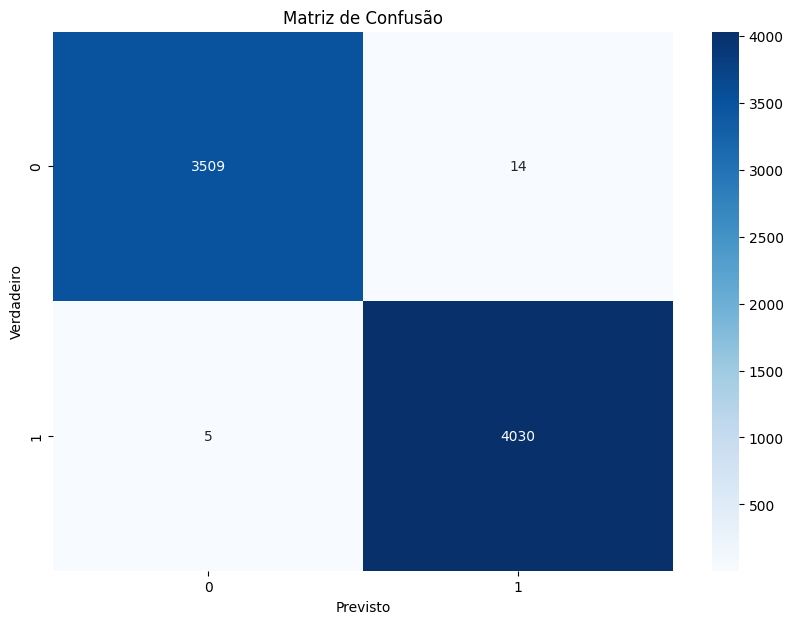

In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão")
plt.show()


Importância das Features:
src_bytes                      0.192286
dst_bytes                      0.091671
same_srv_rate                  0.076346
flag                           0.075173
dst_host_same_srv_rate         0.067838
dst_host_srv_count             0.065104
logged_in                      0.051343
protocol_type                  0.035615
diff_srv_rate                  0.035202
serror_rate                    0.033445
count                          0.030738
srv_serror_rate                0.030353
dst_host_same_src_port_rate    0.028730
dst_host_diff_srv_rate         0.027107
service                        0.023388
srv_count                      0.022245
dst_host_srv_diff_host_rate    0.018265
dst_host_rerror_rate           0.015590
dst_host_count                 0.013811
dst_host_srv_serror_rate       0.012290
dst_host_serror_rate           0.010348
hot                            0.008970
dst_host_srv_rerror_rate       0.007405
srv_rerror_rate                0.006051
num_compromise

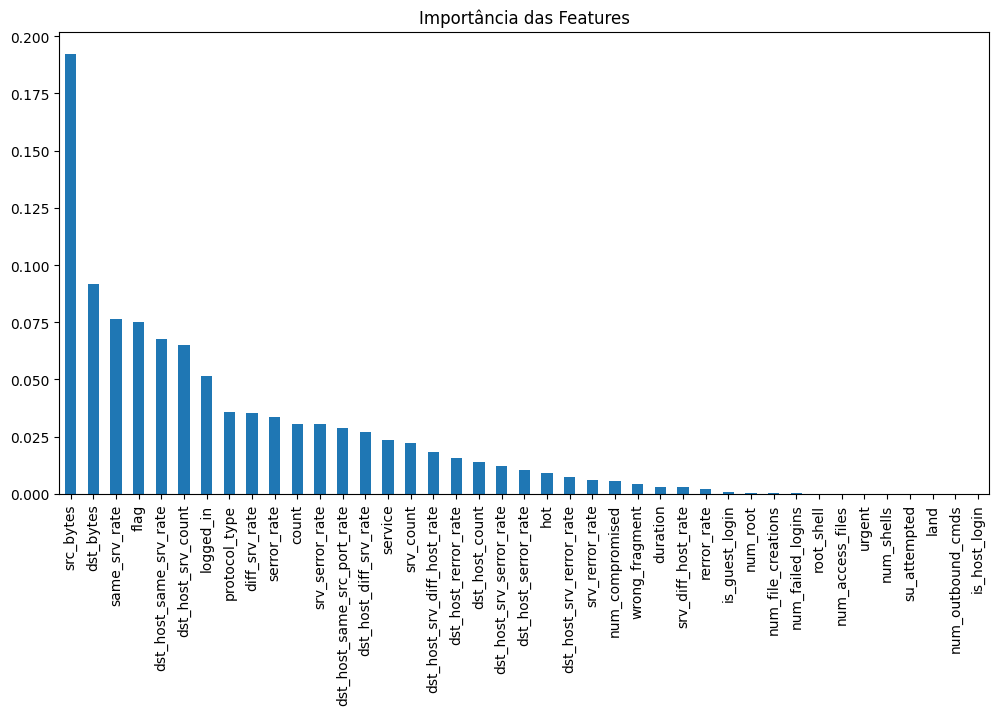

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

print("Importância das Features:")
print(importances)

plt.figure(figsize=(12,6))
importances.plot(kind='bar')
plt.title("Importância das Features")
plt.show()



## 5. Conclusão

O uso do Random Forest para classificação em cibersegurança mostrou-se bastante promissor para a previsão de ataques reais em redes de computadores. O modelo não apenas demonstra alta precisão, como também oferece insights importantes sobre quais características do tráfego de rede são mais indicativas de atividades maliciosas. Esses conhecimentos podem ser aplicados para fortalecer sistemas de detecção de intrusões, permitindo respostas mais rápidas e eficazes contra ameaças cibernéticas. Dessa forma, o estudo reforça a importância do machine learning como uma ferramenta estratégica para proteger ambientes digitais em um cenário de crescentes riscos de segurança.


## 6. Referências

Scikit-learn Documentation. Disponível em: https://scikit-learn.org/stable/. Acesso em: 22 jul. 2025.

Kaggle Dataset – Network Intrusion Detection. Disponível em: https://www.kaggle.com/datasets/sampadab17/network-intrusion-detection. Acesso em: 22 jul. 2025.
    